In [210]:
#Pkg.update()
#using Pkg
Pkg.add("Distributed")

   Resolving package versions...
    Updating `C:\Users\saksh\.julia\environments\v1.10\Project.toml`
  [8ba89e20] + Distributed
  No Changes to `C:\Users\saksh\.julia\environments\v1.10\Manifest.toml`


In [49]:
abspath(PROGRAM_FILE)

"C:\\Users\\saksh\\.julia\\packages\\IJulia\\Vo51o\\src\\kernel.jl"

In [163]:
using Random, UnPack, Serialization, HDF5

In [ ]:
using RegressionDynamicCausalModeling, Plots, MAT

In [ ]:
#dcm = load_example_DCM()
#y, _, _, _ = generate_BOLD(dcm; SNR=10)
#opt = Options(RigidInversionParams();synthetic=true,verbose=1)

In [ ]:
# rdcm = RigidRdcm(dcm)

# #Invert the model (estimate posterior of parameters)
# output = invert(rdcm, opt)

# #Simulate BOLD signal based on estimated parameters
# y_pred = predict(rdcm,output)

In [113]:
subject = "sub-1407"
#nr = 242
#scans = 240
timeseries_path = dirname(pwd())
timeseries_path = joinpath(timeseries_path, "SRPBS_OPEN/data", subject, "glm/VOI")
timeseries_cat = []
for file in readdir(timeseries_path, join=true)
    data = matread(file)
    @unpack Y = data
    timeseries_cat = [timeseries_cat; Y]
end
timeseries_reshape = reshape(timeseries_cat, (scans,nr))

LoadError: DimensionMismatch: new dimensions (240, 242) must be consistent with array size 57840

In [212]:
structconn_path = joinpath(dirname(pwd()), "SRPBS_OPEN/data/Brainnetome2016/StructConn.mat")
structconn = matread(structconn_path)
a_matrix = structconn["adjacency_matrix"];
c_matrix = zeros(nr,scans);

In [213]:
#timeseries_reshape[:,1]
#timeseries_push[1,:]
#timeseries_reshape

In [ ]:
plot(timeseries_reshape[:,1])

In [ ]:
Ep = rDCM.TrueParamLinear(a_matrix,c_matrix)
#Y = Dict(:y=>timeseries_reshape,"dt"=>2.5,"name"=>readdir(timeseries_path))
y = timeseries_reshape
dt = 2.5
name = readdir(timeseries_path)
#InputU(zeros(240,scans),2.5) or nothing?
dcm = LinearDCM(a_matrix,c_matrix,scans,nr,nothing,BoldY(y,dt,name),Ep)

In [137]:
# 1367, 1378, 1380, 1385, 1392 (240), 1402, 1404, 1406, 1407

subject = "sub-1408"
dcm_path = joinpath(dirname(pwd()), "SRPBS_OPEN/data", subject, "DCM.mat")
dcm = load_DCM(dcm_path);

[ Info: No input found-> constructing resting-state DCM.
[ Info: Ep field missing, using default values.
[ Info: Found linear DCM.


In [139]:
dcm_mat = matread(dcm_path)
println(size(dcm_mat["DCM"]["Ep"]))

LoadError: KeyError: key "Ep" not found

In [43]:
rdcm = RigidRdcm(dcm)

rigid rDCM
a:     242x242 matrix
c:     242x1 matrix
scans: 240
nr:    242
HRF:   3840 element vector
---------------------------------------------
U (Input)
   u:  3840x1 matrix
   dt: 0.15625s
   names: null,...,null
---------------------------------------------
Y (BOLD signal)
   y:  240x242 matrix
   dt: 2.5s
   names: VOI_R001_SFG_7_1_left_1,...,VOI_R246_Tha_8_8_right_1
---------------------------------------------
Ep (True parameters)
    A: 242 x 242 matrix
    C: 242 x 0 matrix
    transit: 0.00 ... 0.00
    decay:   0.00 ... 0.00
    epsilon: 0.00
---------------------------------------------
Confounds
   empty


In [44]:
dcm_test = LinearDCM(dcm.a,rdcm.c,dcm.scans,dcm.nr,InputU(rdcm.U.u, rdcm.U.dt),dcm.Y,dcm.Ep)

Linear DCM
a:     242x242 matrix
c:     242x1 matrix
scans: 240
nr:    242
---------------------------------------------
U (Input)
   u:  3840x1 matrix
   dt: 0.15625s
   names: u_1,...,u_1
---------------------------------------------
Y (BOLD signal)
   y:  240x242 matrix
   dt: 2.5s
   names: VOI_R001_SFG_7_1_left_1,...,VOI_R246_Tha_8_8_right_1
---------------------------------------------
Ep (True parameters)
    A: 242 x 242 matrix
    C: 242 x 0 matrix
    transit: 0.00 ... 0.00
    decay:   0.00 ... 0.00
    epsilon: 0.00


In [ ]:
opt = Options(RigidInversionParams(); verbose=2, synthetic=false, rng=MersenneTwister(42))
output = invert(rdcm, opt)

In [ ]:
y_pred = predict(rdcm, output)
plot(timeseries_reshape[:,1])
plot!(y_pred[:,1])

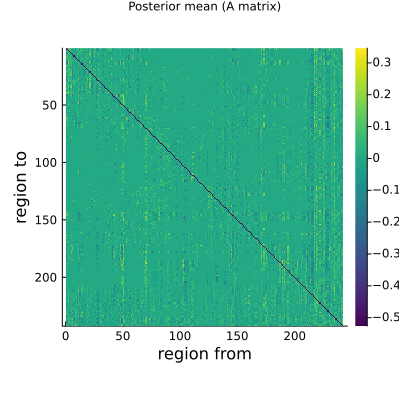

In [226]:
heatmap(
    output.m_all[:,1:end-1];
    yflip=true,
    title="Posterior mean (A matrix)",
    titlefontsize=8,
    c=:viridis,
    xlabel="region from",
    ylabel="region to",
    aspect_ratio=1,
    size=(400, 400),
)

In [45]:
srdcm = SparseRdcm(dcm_test; inform_p0=true, p0=0.20)

sparse rDCM
a:     242x242 matrix
c:     242x2 matrix
scans: 240
nr:    242
HRF:   3840 element vector
---------------------------------------------
U (Input)
   u:  3840x1 matrix
   dt: 0.15625s
   names: u_1,...,u_1
---------------------------------------------
Y (BOLD signal)
   y:  240x242 matrix
   dt: 2.5s
   names: VOI_R001_SFG_7_1_left_1,...,VOI_R246_Tha_8_8_right_1
---------------------------------------------
Ep (True parameters)
    A: 242 x 242 matrix
    C: 242 x 0 matrix
    transit: 0.00 ... 0.00
    decay:   0.00 ... 0.00
    epsilon: 0.00
---------------------------------------------
Confounds
   X0:    3840x1 matrix
   names: Constant,...,Constant
---------------------------------------------
inform_p0:true
p0:0.2


In [ ]:
opt = Options(
    SparseInversionParams(; reruns=50, restrictInputs=true);
    synthetic=false,
    rng=MersenneTwister(42),
)
output_real = invert(srdcm, opt)

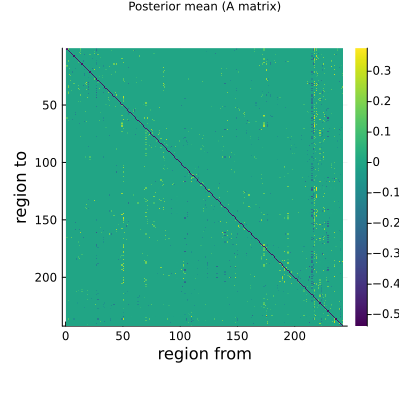

In [40]:
heatmap(
    output_real.m_all[:,1:end-1];
    yflip=true,
    title="Posterior mean (A matrix)",
    titlefontsize=8,
    c=:viridis,
    xlabel="region from",
    ylabel="region to",
    aspect_ratio=1,
    size=(400, 400),
)

In [51]:
output

sparse rDCM output
    F:   -151688.48
    F_r: -646.53 ... -529.37
    iterations until convergence per region: 30 ... 19
    Posteriors:
        α: 122.50,...,122.50
        β: 1130.69,...,509.39
        μ: 242 x 243 matrix
        Σ: 242 element vector of matrices
        Z: 242 x 243 matrix

In [207]:
typeof(output_real.z_all)

Matrix{Float64} (alias for Array{Float64, 2})

In [208]:
output_real.z_all

242×243 Matrix{Float64}:
 1.0          1.0         0.0  0.0  …  0.0         0.0          0.0
 0.0          1.0         0.0  0.0     0.0         0.0          0.0
 0.0          0.0         1.0  0.0     0.0         0.0          0.0
 0.0          0.0         0.0  1.0     0.0         0.0          0.0
 0.0          0.0         0.0  0.0     0.0         0.0          0.0
 0.0          0.0         0.0  0.0  …  0.0         0.0          0.0
 0.0          0.0         0.0  0.0     0.0         0.0          0.0
 0.0          0.0         0.0  0.0     0.0         0.0          0.0
 0.0          0.0         0.0  0.0     0.0         0.0          0.0
 0.0          0.0         0.0  0.0     0.0         0.0          0.0
 0.0          1.0         0.0  0.0  …  0.0         0.0          0.0
 0.0          1.0         0.0  0.0     0.0         0.0          0.0
 0.0          0.0         0.0  0.0     0.0         0.0          0.0
 ⋮                                  ⋱  ⋮                        
 0.0          0.0         

In [146]:
str_ex = "$p0 is $p0"

"0.2 is 0.2"

In [205]:
function save_matrix(matrix, filename::String)
    open(filename, "w") do file
        serialize(file, matrix)
    end
end

save_matrix(output_real.Σ_all, joinpath(pwd(),"output.mat"))

In [ ]:
function load_ser_matrix(filename::String)
    open(filename, "r") do file
        return deserialize(file)
    end
end

output_check = load_ser_matrix(joinpath(pwd(),"output.mat"))

In [174]:
write(joinpath(pwd(),"output.mat"), output.m_all)

470448

In [211]:
function h5_save_output(output_srcdm, output_rdcm, filename::String)
    h5open(filename, "w") do file
        create_group(file, "srdcm")
        create_group(file, "rdcm")
        write(file, "srdcm/m_all", output_srdcm.m_all)
        write(file, "srdcm/F_r", output_srdcm.F_r)
        write(file, "srdcm/z_all", output_srdcm.z_all)
        write(file, "rdcm/m_all", output_rdcm.m_all)
        write(file, "rdcm/F_r", output_rdcm.F_r)
        write(file, "rdcm/z_all", output_rdcm.z_all)
    end
end

h5_save_output (generic function with 1 method)

In [212]:
h5_save_output(output_real,output,joinpath(pwd(),"output.h5"))
save_matrix(output_real.m_all, joinpath(pwd(),"output.mat"))

LoadError: UndefVarError: `output_srdcm` not defined